# Weakly supervised segmentation

## Install packages

In [2]:
# Install packages

# %pip install segmentation_models_pytorch

In [9]:
# Import modules

import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2
from PIL import Image

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import transforms
import segmentation_models_pytorch as smp


# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/cw2-pt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Classifier Training

In [ ]:
# Load datasets for training the classifier

# Define transformations for training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Normalize the images with ImageNet mean and std since we are using ResNet which is pretrained on ImageNet
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load the dataset
print("Loading dataset...")
train_dataset = OxfordIIITPet(root='../data',
                             split='trainval',
                             target_types="category",
                             transform=transform,
                             download=True)

test_dataset = OxfordIIITPet(root='../data',
                           split='test',
                           target_types="category",
                           transform=transform,
                           download=True)

train_dataloader = 

Loading dataset...


In [13]:
# CAM Model using ResNet backbone
class CAMModel(nn.Module):
    def __init__(self, num_classes=37):  # Oxford-IIIT Pet has 37 categories
        super(CAMModel, self).__init__()
        # Load a pre-trained ResNet
        self.resnet = torchvision.models.resnet50(weights='IMAGENET1K_V1')

        # Remove the final fully connected layer
        self.features = nn.Sequential(*list(self.resnet.children())[:-2])

        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d(1)

        # Classification layer
        self.fc = nn.Linear(2048, num_classes)  # 2048 is output channels for ResNet-50

    def forward(self, x):
        # Feature extraction
        features = self.features(x)

        # Save features for CAM generation
        self.last_features = features

        # Global Average Pooling
        x = self.gap(features)
        x = x.view(x.size(0), -1)

        # Classification
        x = self.fc(x)
        return x

In [14]:
def train_model(model, train_loader, num_epochs=5):
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model = model.to(device)

    print(f"Training on {device}...")

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')

    # Save the model checkpoint
    torch.save(model.state_dict(), 'cam_model.pth')
    return model


In [18]:
print("Creating model...")
model = CAMModel()

# Set to True if you want to train, False to load pre-trained
TRAIN_MODEL = False

if TRAIN_MODEL:
    model = train_model(model, train_dataloader, num_epochs=20)
else:
    # Load pretrained model if it exists
    if os.path.exists('models/cam_model.pth'):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.load_state_dict(torch.load('models/cam_model.pth', map_location=device, weights_only=False))
        model = model.to(device)
        print("Loaded pre-trained model")
    else:
        print("No pre-trained model found, training new model")
        model = train_model(model, train_dataloader, num_epochs=5)

Creating model...
Loaded pre-trained model


## Generate the CAMs

In [19]:
def generate_cam(model, img, label, threshold):
    """
    Generate Class Activation Map for an image.

    Args:
        model: The trained model with CAM capability
        img_tensor: Preprocessed image tensor
        label: Class label for which to generate CAM

    Returns:
        CAM numpy array
    """
    device = next(model.parameters()).device
    model.eval()

    # Forward pass
    with torch.no_grad():
        output = model(img.unsqueeze(0).to(device))

    # Get weights from the final FC layer for the specified class
    fc_weights = model.fc.weight[label].cpu()

    # Get feature maps from the last convolutional layer
    feature_maps = model.last_features.squeeze(0).cpu()

    # Calculate weighted sum of feature maps
    cam = torch.zeros(feature_maps.shape[1:])
    for i, weight in enumerate(fc_weights):
        cam += weight * feature_maps[i]

    # Apply ReLU and normalize
    cam = torch.maximum(cam, torch.tensor(0.0))
    if cam.max() > 0:
        cam = cam / cam.max()

    # Convert to numpy and resize
    cam = cam.detach().numpy()

    # Create CAM mask
    mask = (cam >= threshold).astype(np.uint8)

    return cam, mask

In [20]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet
from PIL import Image

class CAMSegmentationDataset(Dataset):
    def __init__(self, base_dataset, cam_dir,
                 transform=None, target_transform=None):
        """
        Create a dataset using pre-existing CAM masks.

        Args:
            base_dataset: Original image dataset (e.g., OxfordIIITPet)
            cam_dir: Directory containing pre-generated CAM masks
            transform: Transformations for input images
            target_transform: Transformations for masks
        """
        self.base_dataset = base_dataset
        self.cam_dir = cam_dir

        # Default image transform (if not provided)
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

        # Default mask transform (if not provided)
        self.target_transform = target_transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

        # Generate list of mask paths
        self.mask_paths = self._get_mask_paths()

    def _get_mask_paths(self):
        """
        Find all mask paths in the specified directory.

        Returns:
            List of full paths to mask files
        """
        mask_paths = []
        for filename in os.listdir(self.cam_dir):
            if filename.startswith('cam_mask_') and filename.endswith('.png'):
                mask_paths.append(os.path.join(self.cam_dir, filename))

        # Sort to ensure consistent ordering
        mask_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split('_')[-1]))

        # Verify we have the correct number of masks
        assert len(mask_paths) == len(self.base_dataset), \
            f"Number of masks ({len(mask_paths)}) does not match dataset size ({len(self.base_dataset)})"

        return mask_paths

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        # Get original image
        orig_img, label = self.base_dataset[idx]

        # Ensure we're working with a PIL Image
        if not isinstance(orig_img, Image.Image):
            orig_img = transforms.ToPILImage()(orig_img)

        # Apply image transform
        img = self.transform(orig_img)

        # Load mask
        mask = Image.open(self.mask_paths[idx]).convert('L')

        # Apply mask transform
        mask = self.target_transform(mask)

        return img, mask

# Example usage
def prepare_cam_segmentation_dataset(train_dataset, test_dataset):
    """
    Prepare CAM segmentation datasets using pre-existing masks.

    Args:
        train_dataset: Original training dataset
        test_dataset: Original test dataset

    Returns:
        cam_train_dataset, cam_test_dataset
    """
    cam_train_dataset = CAMSegmentationDataset(
        base_dataset=train_dataset,
        cam_dir='./cam_masks/train'
    )

    cam_test_dataset = CAMSegmentationDataset(
        base_dataset=test_dataset,
        cam_dir='./cam_masks/test'
    )

    return cam_train_dataset, cam_test_dataset

In [21]:
# Assuming you have already trained a classification model
# Load your trained classification model
print("Creating model...")
model = CAMModel()

# Set to True if you want to train, False to load pre-trained
TRAIN_MODEL = False

if TRAIN_MODEL:
    model = train_model(model, train_dataloader, num_epochs=20)
else:
    # Load pretrained model if it exists
    if os.path.exists('cam_model.pth'):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.load_state_dict(torch.load('cam_model.pth', map_location=device, weights_only=False))
        model = model.to(device)
        print("Loaded pre-trained model")
    else:
        print("No pre-trained model found, training new model")
        model = train_model(model, train_dataloader, num_epochs=5)

# Prepare CAM segmentation datasets
cam_train_dataset, cam_test_dataset = prepare_cam_segmentation_dataset(
    train_dataset, test_dataset
)

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    cam_train_dataset,
    batch_size=32,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    cam_test_dataset,
    batch_size=32,
    shuffle=False
)

Creating model...
No pre-trained model found, training new model


NameError: name 'train_dataloader' is not defined

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
import numpy as np

class SegmentationTrainer:
    def __init__(self, model, train_loader, val_loader, device='cuda'):
        """
        Initialize the segmentation model trainer.

        Args:
            model: Segmentation model (U-Net)
            train_loader: DataLoader for training data
            val_loader: DataLoader for validation data
            device: Computing device (cuda/cpu)
        """
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device

        # Loss function (Dice + BCE)
        self.loss_fn = nn.BCEWithLogitsLoss()

        # Optimizer
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-4, weight_decay=1e-5)

        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    def train_epoch(self):
        """
        Train for one epoch.

        Returns:
            Average loss for the epoch
        """
        self.model.train()
        total_loss = 0

        for images, masks in self.train_loader:
            images = images.to(self.device)
            masks = masks.to(self.device)

            # Zero gradients
            self.optimizer.zero_grad()

            # Forward pass
            predictions = self.model(images)

            # Compute loss
            loss = self.loss_fn(predictions, masks)

            # Backward pass
            loss.backward()

            # Optimizer step
            self.optimizer.step()

            total_loss += loss.item()

        return total_loss / len(self.train_loader)

    def validate(self):
        """
        Validate the model.

        Returns:
            Average validation loss
        """
        self.model.eval()
        total_loss = 0

        with torch.no_grad():
            for images, masks in self.val_loader:
                images = images.to(self.device)
                masks = masks.to(self.device)

                # Forward pass
                predictions = self.model(images)

                # Compute loss
                loss = self.loss_fn(predictions, masks)

                total_loss += loss.item()

        return total_loss / len(self.val_loader)

    def train(self, epochs=50):
        """
        Full training loop.

        Args:
            epochs: Number of training epochs
        """

        best_val_loss = float('inf')

        for epoch in range(epochs):
            # Train for one epoch
            train_loss = self.train_epoch()

            # Validate
            val_loss = self.validate()

            # Learning rate scheduling
            self.scheduler.step(val_loss)

            # Logging
            print(f"Epoch {epoch+1}/{epochs}")
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Val Loss: {val_loss:.4f}")

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(
                    self.model.state_dict(),
                    'best_unet_model.pth'
                )

In [ ]:
def main():
    # Assume you have your CAM datasets prepared from previous steps
    # Create U-Net model
    model = smp.Unet(
        encoder_name='resnet34', # Choose encoder
        encoder_weights='imagenet', # Use pretrained weights
        in_channels=3, # RGB images
        classes=1, # Binary segmentation
        activation=None # Logits for loss calculation
    )
    # 3. Perform your train/val split
    seed = 42
    torch.manual_seed(seed)

    train_size = int(0.8 * len(cam_train_dataset))
    val_size = len(cam_train_dataset) - train_size
    train_dataset, val_dataset = random_split(cam_train_dataset, [train_size, val_size])

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=16,
        shuffle=True,
        num_workers=2
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=16,
        shuffle=False,
        num_workers=2
    )

    # Initialize trainer
    trainer = SegmentationTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader
    )

    # Train the model
    trainer.train(epochs=5)

if __name__ == "__main__":
    main()

NameError: name 'smp' is not defined

## Self-training

In [22]:
import os
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms.functional import to_pil_image

def generate_pseudo_masks(model, dataset, save_dir, device, threshold=0.5):
    """
    Generate and save pseudo masks for a dataset using the current model.
    """
    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    print(f"Generating pseudo masks to: {save_dir}")

    with torch.no_grad():
        for idx in range(len(dataset)):
            img, _ = dataset[idx]  # We don’t use the CAM-based label here
            img_input = img.unsqueeze(0).to(device)

            pred = model(img_input)
            prob = torch.sigmoid(pred).squeeze().cpu()
            binary_mask = (prob > threshold).float()

            # Convert to PIL image and save
            pil_mask = to_pil_image(binary_mask)
            save_path = os.path.join(save_dir, f"cam_mask_{idx}.png")
            pil_mask.save(save_path)


def self_training_loop(model_init_fn, base_dataset, initial_mask_dir, num_phases=3, epochs_per_phase=2, device='cuda'):
    """
    Self-training loop that updates the dataset and retrains the model.

    Args:
        model_init_fn: function that returns a new segmentation model
        base_dataset: dataset of training images
        initial_mask_dir: directory of CAM masks
        num_phases: number of self-training rounds
        epochs_per_phase: number of epochs per round
    """
    current_mask_dir = initial_mask_dir

    for phase in range(num_phases):
        print(f"\n=== Phase {phase + 1} / {num_phases} ===")

        # Build dataset using current pseudo labels
        train_dataset = CAMSegmentationDataset(
            base_dataset=base_dataset,
            cam_dir=current_mask_dir
        )

        # Split into train/val
        train_size = int(0.8 * len(train_dataset))
        val_size = len(train_dataset) - train_size
        train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

        train_loader = DataLoader(train_subset, batch_size=16, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_subset, batch_size=16, shuffle=False, num_workers=2)

        # Create fresh model and trainer
        model = model_init_fn().to(device)
        trainer = SegmentationTrainer(model, train_loader, val_loader, device=device)

        # Train for a few epochs
        trainer.train(epochs=epochs_per_phase)

        # Save new pseudo labels from the updated model
        current_mask_dir = f'./pseudo_masks/phase_{phase + 1}'
        generate_pseudo_masks(model, base_dataset, current_mask_dir, device=device)
    print("Self-training complete!")

In [23]:
def model_init_fn():
    return smp.Unet(
        encoder_name='resnet34',
        encoder_weights='imagenet',
        in_channels=3,
        classes=1,
        activation=None
    )

self_training_loop(
    model_init_fn=model_init_fn,
    base_dataset=train_dataset,  # The original OxfordIIITPet images
    initial_mask_dir='./cam_masks/train',  # CAM mask directory
    num_phases=5,
    epochs_per_phase=2,
    device='cuda'
)


=== Phase 1 / 5 ===


FileNotFoundError: [Errno 2] No such file or directory: './cam_masks/train'

## Evaluation and visualisation of outputs

In [52]:
class OxfordPetsBinaryTrimapDataset(Dataset):
    def __init__(self, dataset, trimap_dir, transform=None, target_transform=None):
        self.dataset = dataset
        self.trimap_dir = trimap_dir

        self.transform = transform or transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

        self.target_transform = target_transform or transforms.Compose([
            transforms.Resize((256, 256), interpolation=Image.NEAREST)
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]

        # Check if img is already a tensor
        if isinstance(img, torch.Tensor):
            # If it is a tensor, convert it to PIL Image
            img = transforms.ToPILImage()(img)

        # Directly access the _images attribute of the OxfordIIITPet dataset
        img_path = self.dataset._images[idx]  # Access _images directly
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        mask_path = os.path.join(self.trimap_dir, base_name + '.png')

        # Load and process mask
        mask = Image.open(mask_path).convert('L')
        mask = self.target_transform(mask)
        mask = np.array(mask)

        # Binary conversion: 1 → 1 (pet), 2/3 → 0 (uncertain + background)
        binary_mask = (mask == 1).astype(np.uint8)

        return self.transform(img), torch.LongTensor(binary_mask) # Apply transform to the PIL image

In [53]:
from sklearn.metrics import accuracy_score, recall_score, jaccard_score, f1_score
import numpy as np
import tqdm

def evaluate_binary_model_metrics(model, dataloader, device):
    model.eval()

    total_accuracy = 0
    total_recall = 0
    total_jaccard = 0
    total_f1 = 0
    total_samples = 0

    with torch.no_grad():
        for images, targets in tqdm.tqdm(dataloader):
            images = images.to(device)
            targets = targets.numpy()  # (B, H, W)

            outputs = model(images)
            probs = torch.sigmoid(outputs).squeeze(1).cpu().numpy()
            preds = (probs > 0.5).astype(np.uint8)  # Binarize predictions

            # Flatten all pixels
            total_accuracy += accuracy_score(targets.flatten(), preds.flatten()) * len(targets)
            total_recall += recall_score(targets.flatten(), preds.flatten(), average='binary') * len(targets)
            total_jaccard += jaccard_score(targets.flatten(), preds.flatten(), average='binary') * len(targets)
            total_f1 += f1_score(targets.flatten(), preds.flatten(), average='binary') * len(targets)
            total_samples += len(targets)

    metrics = {
        'accuracy': total_accuracy / total_samples,
        'recall': total_recall / total_samples,
        'jaccard': total_jaccard / total_samples,
        'f1': total_f1 / total_samples
    }

    print(f"\nModel Performance Metrics (Binary Trimaps):")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"Jaccard Index: {metrics['jaccard']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")

    return metrics

In [54]:
# Binary trimap dataset
binary_test_dataset = OxfordPetsBinaryTrimapDataset(
    dataset=test_dataset,
    trimap_dir='./data/annotations/trimaps'
)

test_loader = DataLoader(binary_test_dataset, batch_size=32, shuffle=False)

# Load binary U-Net (1 output class)
model = smp.Unet(
    encoder_name='resnet34',
    encoder_weights='imagenet',
    in_channels=3,
    classes=1,
    activation=None
)
model.load_state_dict(torch.load('best_unet_model.pth', map_location=device))
model = model.to(device)

# Evaluate
evaluate_binary_model_metrics(model, test_loader, device)

100%|██████████| 115/115 [02:05<00:00,  1.10s/it]


Model Performance Metrics (Binary Trimaps):
Accuracy: 0.7116
Recall: 0.0605
Jaccard Index: 0.0588
F1 Score: 0.1099


{'accuracy': 0.7116454470934157,
 'recall': 0.06046928864383128,
 'jaccard': np.float64(0.058844128071502556),
 'f1': 0.10985374462040125}

In [55]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_binary_predictions(model, dataset, device, num_samples=4):
    """
    Visualizes predictions from a binary segmentation model.

    Args:
        model: Trained PyTorch model
        dataset: Dataset (must return image, binary mask)
        device: 'cuda' or 'cpu'
        num_samples: Number of samples to visualize
    """
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        img, true_mask = dataset[i]
        img_input = img.unsqueeze(0).to(device)

        with torch.no_grad():
            pred_logits = model(img_input)
            pred_mask = torch.sigmoid(pred_logits).squeeze().cpu().numpy()
            pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)

        # Reverse normalization for visualization
        img_vis = img.clone()
        img_vis = img_vis * torch.tensor([0.229, 0.224, 0.225])[:, None, None]
        img_vis = img_vis + torch.tensor([0.485, 0.456, 0.406])[:, None, None]
        img_vis = img_vis.clip(0, 1).permute(1, 2, 0).numpy()

        # Plot original image
        axes[i, 0].imshow(img_vis)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        # Plot ground truth
        axes[i, 1].imshow(true_mask.numpy(), cmap="gray")
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis("off")

        # Plot prediction
        axes[i, 2].imshow(pred_mask_bin, cmap="gray")
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

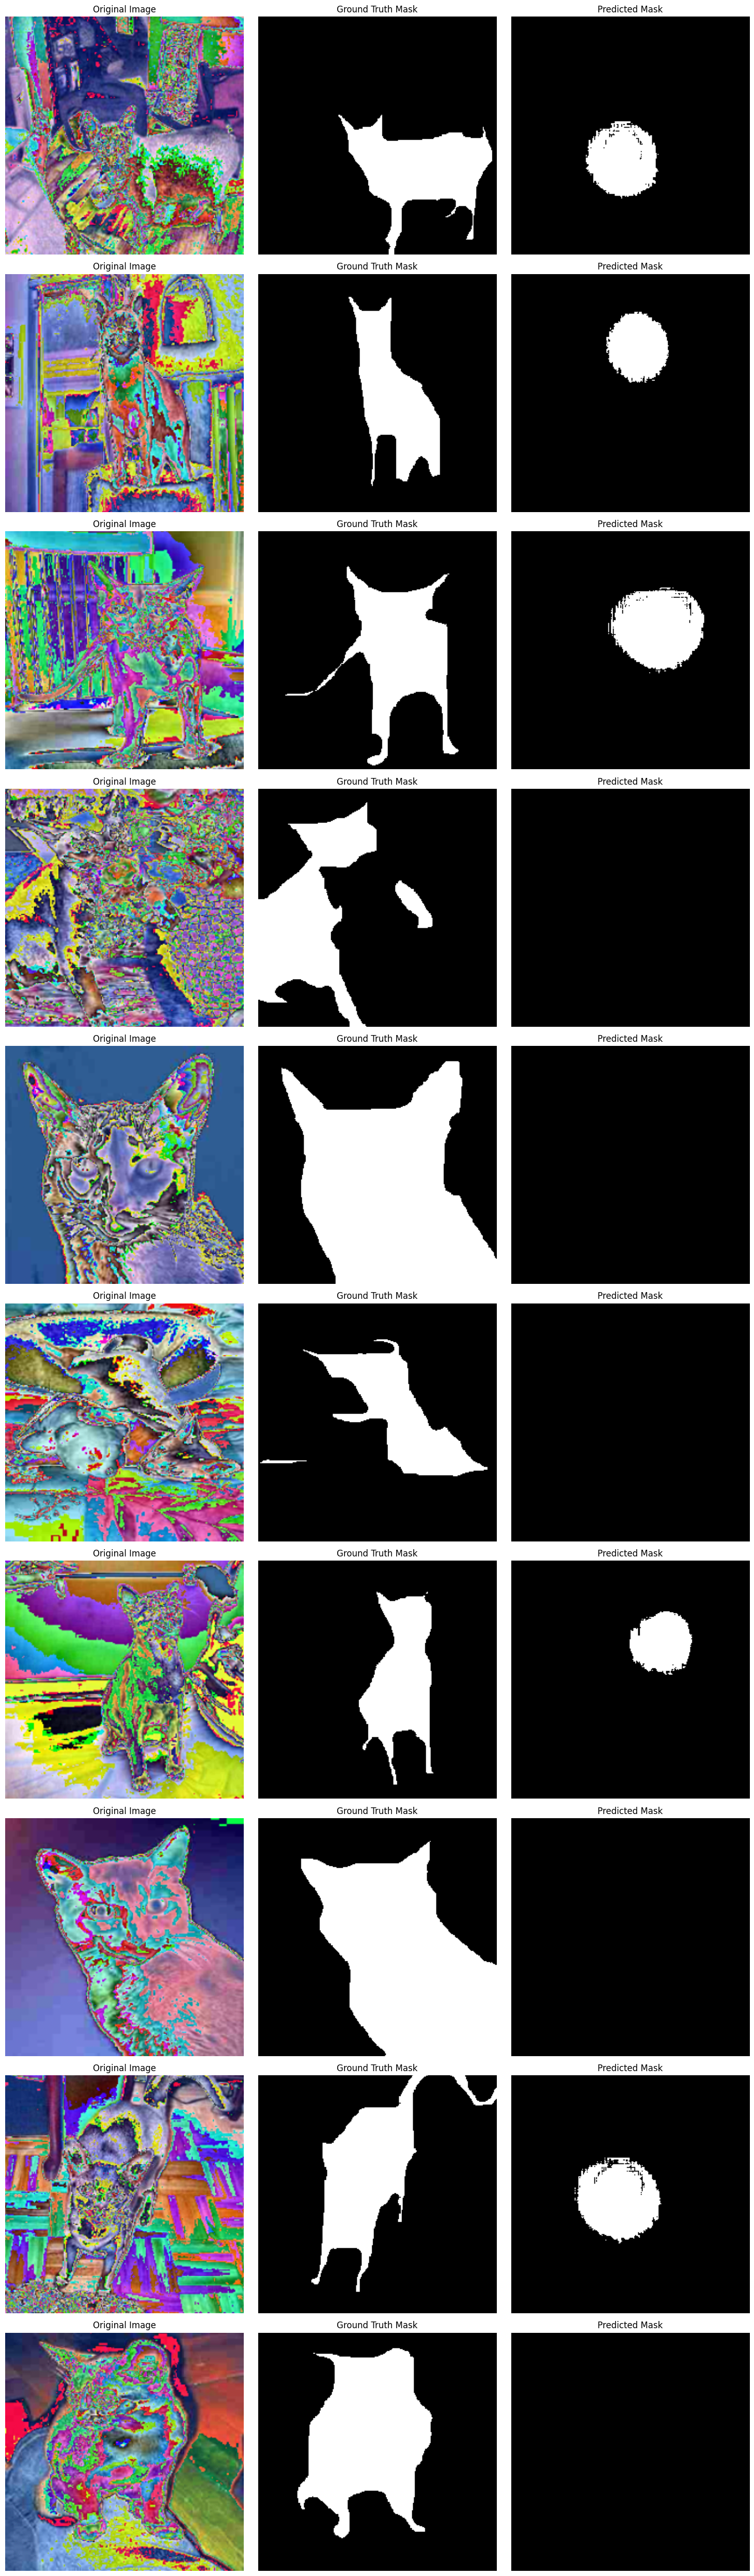

In [57]:
visualize_binary_predictions(model, binary_test_dataset, device='cuda', num_samples=10)